In [1]:
import pandas as pd
import numpy as np

from PIL import Image, ImageStat
import math
from tqdm import tqdm
import time, cv2
import pickle
import itertools # Pour créer des iterateurs


import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.image as mpimg
from matplotlib import offsetbox
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import Isomap
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


# Set your path(s)...!!!

In [2]:
csv_full = r"C:\Users\tyle_\DataScientest\MushPy\reduced_dataset_5_families_Copie.csv"

folder_data = r'C:\Users\tyle_\DataScientest\MushPy\images\2nd try\images_mushroom\\'

### Load csv_full

In [3]:
df = pd.read_csv(csv_full)


folderpath = str(r'C:\Users\tyle_\DataScientest\MushPy\images\2nd try\images_mushroom\\')
df['filepath'] = [folderpath + str(df['image_id'][x]) + ".jpg" for x in range(len(df))]

df = df.sample(n=len(df)//8)   #  if you take a sample higher than 1000, some cells will be very VERY long to run

df.head()

,image_id,image_url,family,filepath,label
3653,132666,http://mushroomobserver.org/images/320/132666,Inocybaceae,C:\Users\tyle_\DataScientest\MushPy\images\2nd...,0
2525,89347,http://mushroomobserver.org/images/320/89347,Inocybaceae,C:\Users\tyle_\DataScientest\MushPy\images\2nd...,0
418,8526,http://mushroomobserver.org/images/320/8526,Physalacriaceae,C:\Users\tyle_\DataScientest\MushPy\images\2nd...,3
8357,316245,http://mushroomobserver.org/images/320/316245,Omphalotaceae,C:\Users\tyle_\DataScientest\MushPy\images\2nd...,1
6547,243485,http://mushroomobserver.org/images/320/243485,Marasmiaceae,C:\Users\tyle_\DataScientest\MushPy\images\2nd...,4


### Check the first picture in the dataframe

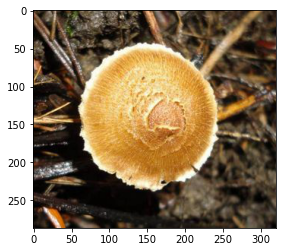

In [4]:
img = Image.open(df['filepath'].iloc[0]) # load the picture
aimg = np.asarray(img)                   # transform the picture in an array

plt.imshow(aimg);                        # show the picture

### Split data :

In [5]:
X_train_path, X_test_path, y_train, y_test = train_test_split(df['filepath'], df['label'], test_size=0.2, random_state=1234)

In [6]:
size = 128         # set the size of the pictures here

### Load X_test images :

In [7]:
# some images in the dataset were with different charateristics than the majority of the other ones
# I decided to separate them from the other ones as it was only drawings which were not part of our study

imgBW = []         # create a list for images black & white
y_testBW = []      # create a list for y_test with images black & white
y_test = []        # create a list for y_test with images in colors
X_test = []        # create a list for X_test with images in colors

i=0                # counter initialization

for filepath in tqdm(X_test_path):       # this loop separate B&W images from the other ones and load our images + transform them by resizing and removing the colors from the pictures 
    
    img = Image.open(filepath)           # load picture
    img_test_RGB = img.getcolors()       # => check if there are colors or not on the picture
    
    if img_test_RGB != None:             # separate  B&W pictures & transform + add them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        imgBW.append(img)
        y_testBW.append(df['label'].iloc[i])
        i += 1
        
    else:                                # transform & add pictures them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        aimg = np.asarray(img)
        R, G, B = aimg[:,:,0], aimg[:,:,1], aimg[:,:,2]
        imggray = 0.2989 * R + 0.5870 * G + 0.1140 * B
        imggray_0, imggray_1 = imggray.shape
        D1_imggray = imggray.reshape([imggray_0*imggray_1])
        X_test.append(D1_imggray)
        y_test.append(df['label'].iloc[i])
        i += 1

X_test = np.asarray(X_test)              # transform X_test from list to np.array
y_test = np.asarray(y_test)              # transform y_test from list to np.array

100%|██████████| 429/429 [00:03<00:00, 122.95it/s]


### Load X_train images :

In [8]:
# Same thing than previously, some images in the dataset were with different charateristics than the majority of the other ones
# I decided to separate them from the other ones as it was only drawings which were not part of our study


imgBW = []         # create a list for images black & white
y_trainBW = []      # create a list for y_train with images black & white
y_train = []        # create a list for y_train with images in colors
X_train = []        # create a list for X_train with images in colors

i=0                # counter initialization

for filepath in tqdm(X_train_path):    # this loop separate B&W images from the other ones and load our images + transform them by resizing and removing the colors from the pictures 
    
    img = Image.open(filepath)         # load picture
    img_test_RGB = img.getcolors()     # => check if there are colors or not on the picture
    
    if img_test_RGB != None:           # separate  B&W pictures & transform + add them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        imgBW.append(img)
        y_trainBW.append(df['label'].iloc[i])
        i += 1
    else:                              # transform & add pictures them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        aimg = np.asarray(img)
        R, G, B = aimg[:,:,0], aimg[:,:,1], aimg[:,:,2]
        imggray = 0.2989 * R + 0.5870 * G + 0.1140 * B
        imggray_0, imggray_1 = imggray.shape
        D1_imggray = imggray.reshape([imggray_0*imggray_1])
        X_train.append(D1_imggray)
        y_train.append(df['label'].iloc[i])
        i += 1

#X_train = np.concatenate(X_train, axis=0)

X_train = np.asarray(X_train)          # transform X_train from list to np.array
y_train = np.asarray(y_train)          # transform y_train from list to np.array

100%|██████████| 1713/1713 [00:12<00:00, 136.77it/s]


### Check the first picture from X_train

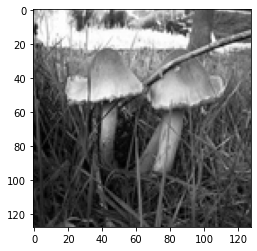

In [9]:
plt.imshow(X_train[0].reshape([size,size]), cmap='gray');

### Let's have a look about few pictures of our dataset

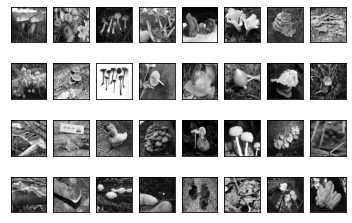

In [10]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_train[i].reshape(size,size), cmap='gray')

### Let's reduce the dimensions of our dataset by deleting the less informative pixels.
In this way, our model won't be trained on useless pixels

Cell execution time :00:00:00.90


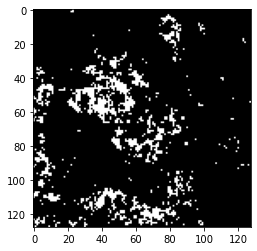

In [13]:
start = time.time()

sel = SelectPercentile(percentile = 90)
sel.fit(X_train, y_train)

X_train_red = sel.transform(X_train)
X_test_red = sel.transform(X_test)


plt.imshow(sel.get_support().reshape(size,size), cmap = 'gray_r');

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Cell execution time :{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

The less informative pixels are in white on the pictures. There is no conclusion, is **the less informative pixels are a bit everywhere on the pictures**.

### Let's define a function `plot_reduced_image` to show a picture from which we withdraw some pixels by specifying the reduced data and the selector to use in order to recollect the mask


In [14]:
def plot_reduced_image(image, selector):
    mask = selector.get_support()
    #toprint = [image[i] if mask[i] == True else 0 for i in range(sum(mask))]
    fullimg = np.array([])
    cnt = 0
    for i in range(size*size):
        if mask[i]:
            fullimg = np.append(fullimg, image[i-cnt])
        else:
            fullimg = np.append(fullimg, 0)
            cnt += 1
    plt.imshow(fullimg.reshape(size,size), cmap = 'gray')

### Let's see the result of our new function with the first picture of our dataset 

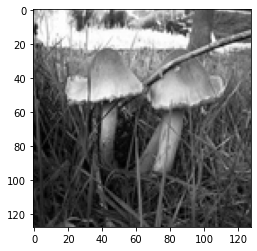

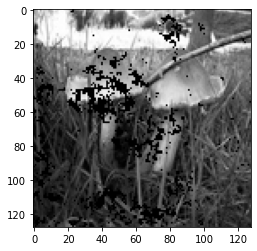

In [15]:
plt.figure()
plt.imshow(X_train[0].reshape(size,size), cmap = 'gray')
plt.show();
plot_reduced_image(X_train_red[0], sel)

### we can still easily recognize the mushroom.

### Let's now apply a PCA on the reduced images

The cell below can be very long to run if the dataset is higher than 1000 items in it

In [16]:
start = time.time()

pca = PCA(n_components = .9)
X_train_pca = pca.fit_transform(X_train_red)
X_test_pca = pca.transform(X_test_red)

print("New dimensions of our dataset after PCA :",pca.n_components_)

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Cell execution time :{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

New dimensions of our dataset after PCA : 418
Cell execution time :00:00:26.20


In [17]:
X_train_samples, X_train_dimensions  = X_train.shape
print("Our dataset is now with", pca.n_components_,"dimensions, instead of", X_train_dimensions," ( size =",size,")")

Our dataset is now with 418 dimensions, instead of 16384  ( size = 128 )


Let's see the 'eigenfaces' which are the first main components of the PCA bringing the most variance

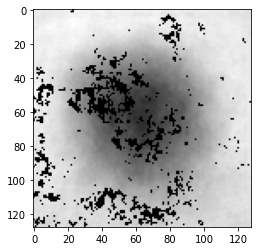

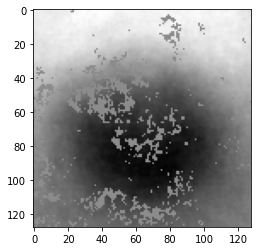

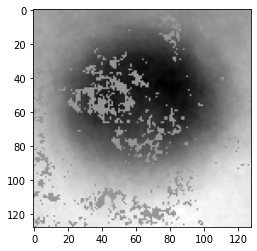

In [18]:
for i in range(3):
    plt.figure()
    plot_reduced_image(pca.components_[i], sel)
    plt.show();

### Not so sure that there is anything left from the mushroom...

In [19]:
start = time.time()

svc = SVC(C = 1, kernel = 'linear')
svc.fit(X_train_pca, y_train)
print("Score on reduced data :", svc.score(X_test_pca, y_test))

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Cell execution time :{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Score on reduced data : 0.2112676056338028
Cell execution time :00:00:34.65


In [20]:
# Save the Modle to file in the current working directory

Pkl_Filename = "Pickled_SVC_Model_with_1_8_dataset.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(svc, file)

In [21]:
"""
# Load the Model back from file

with open('Pickled_SVC_Model_with_1_8_dataset.pkl', 'rb') as file:  
    SVC = pickle.load(file)

SVC
"""

"\n# Load the Model back from file\n\nwith open(Pkl_Filename, 'rb') as file:  \n    Pickled_SVC_Model_with_1_8_dataset = pickle.load(file)\n\nPickled_SVC_Model_with_1_8_dataset\n"

### Predict X_test and get the prediction

In [23]:
y_pred = svc.predict(X_test_pca)

In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.22      0.25      0.23        99
           1       0.23      0.26      0.24        87
           2       0.24      0.19      0.21        79
           3       0.20      0.20      0.20        83
           4       0.17      0.13      0.14        78

    accuracy                           0.21       426
   macro avg       0.21      0.21      0.21       426
weighted avg       0.21      0.21      0.21       426



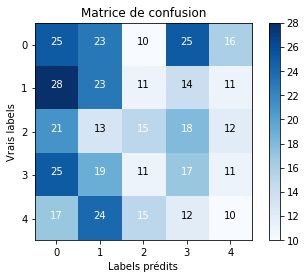

In [24]:
cnf_matrix = confusion_matrix(y_test, y_pred)

classes = range(0,(df['family'].nunique()))

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

The svc model has **mainly predicted on label 0 and on label 1** with more or less the same amounts.
Some predictions with the other labels and when it did, it was with poor results. **We can't conclude that we have good predictions on several labels or even one label** as it doesn't look like that the svc model really recognizes labels. **It just predict mainly on label 0 or 1**.